In [1]:
import numpy as np
from numpy.linalg import multi_dot
import matplotlib.pyplot as plt
import os
from sklearn.utils.extmath import randomized_svd
from skimage import color


## Preliminary Functions

In order to implement the eigenface and fisherface algorithm, we need to be able to express images numerically. 

This first function converts an image to a vector by first converting the image to a matrix and then stacking the rows of that matrix into a single column. If the dimensions of each image are $ 192 $ by $ 168 $, then the length of the vector is $ 192 * 168 = 32256 $.


In [2]:
def vector(file):
    img = plt.imread(file)
    if img.ndim != 2:
        img = color.rgb2gray(img)
    vector = img.ravel()
    mean = np.mean(vector)
    vector = 1/mean * vector
    return vector

We'll be reading entire folders full of images. We'll need a function that can read through a folder of images and create an image matrix where the columns are the column vectors of images. 

For example, if we're dealing with a folder of $ 20 $ images, each with dimensions $ 192 $ by $ 168 $, then the matrix created by this function will have dimensions $ 32256 $ by $ 20 $.

In [3]:
def compile_images(foldername):
    counter = 0
    sorted_folder = os.listdir(foldername)
    if '.DS_Store' in sorted_folder:
        sorted_folder.remove('.DS_Store')
    sorted_folder.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))
    for file in sorted_folder:
        img = os.fsdecode(file)
        if counter == 0:
            matrix = vector(foldername + '/' + img).T
            counter += 1
        else:
            matrix = np.c_[matrix, vector(foldername + '/' + img)]
    return matrix

Finally, we want to have a function that reconstructs our image from its vector form. This is not essential for the algorithm, but will allow us to see what the eigenfaces and fisherfaces actually look like later...

In [4]:
def image(vector, m, n):
    img = np.asarray(vector).reshape(m, n)
    plt.imshow(img, cmap=plt.get_cmap('gray'))
    plt.axis('off')
    plt.show()

## Eigenfaces

The code for eigenfaces is quite simple. The math is a bit more complicated. I'll go through that here.

Consider a database matrix $ A $. This will be our training dataset. Each column of $ A $ represents a real face from the Yale face database. In other words, $ A $ is the result of putting our database folder through the ```compile_images``` function. 

Since I am using a database with $ 1513 $ faces, $ A $ will have dimensions $ 32256 $ by $ 1513 $:



In [8]:
A = np.load('Desktop/6.0001/A.npy') # Make sure to change the file path
A.shape

(32256, 1513)

We now need to center the data around zero (this will be useful for the PCA dimensionality reduction later). This can be accomplished by subtracting the average face from each column of $ A $:

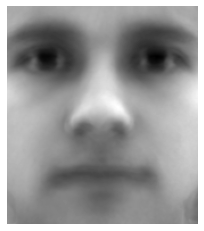

In [9]:
phi = np.load('Desktop/6.0001/phi.npy') # Again, change the file path

Phi = np.dot(phi.T, np.array([np.ones(A.shape[1])]))

# Phi is a matrix whose every column is the the average face, phi

A = A - Phi 

# Just for fun, we can see what the average face looks like:

image(phi, 192, 168)

Now comes the eigenface component.

Eigenfaces are the principal components of $ A $. In other words, taking the SVD of $ A $:

$$ A = U \Sigma V^{T} $$

The eigenfaces are the columns of $ U $. These columns have the same dimensions as each face vector, so we can see what they look like:

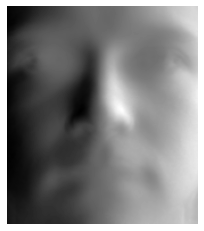

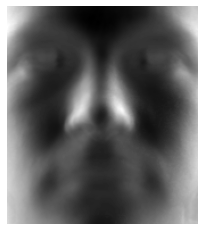

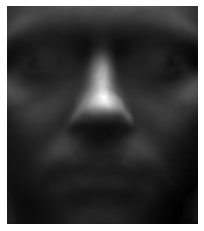

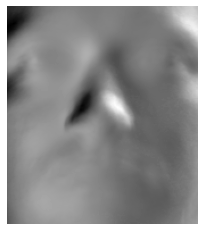

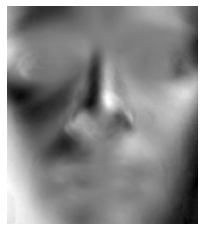

In [12]:
def eigenfaces(A, phi, r):
    Phi = np.dot(phi.T, np.array([np.ones(A.shape[1])]))
    A = A - Phi # substracting the average column from every column in A to center the data around zero
    U, S, VT = randomized_svd(A, n_components = r) # SVD
    return U

U = np.load('Desktop/6.0001/U.npy') # Loading U in; the SVD takes too long

for n in range(5):
    image(U.T[n], 192, 168)

Notice how the first few eigenfaces primarily capture lighting differences. Since our database, $ A $, contains muliple different lighting conditions, it makes sense that the principal components of $ A $ would capture the most common lighting orientations.  

### Face Classification Using Eigenfaces

Eigenfaces provides us with an orthonormal basis, $ U $, of eigenfaces. Since we're interesting only in the primary components of the data, we heuristically choose a number of eigenfaces (in this case, I chose $ r = 40 $) to use. This means $ U $ contains only the first $ 40 $ eigenfaces of $ A $.

Say we want to determine whether two images, $ \gamma_1 $ and $ \gamma_2 $, are the same.

We first multiply each vector by $ U^{T} $:

$$ \gamma_1^{'} = U^{T}\gamma_1 $$
$$ \gamma_2^{'} = U^{T}\gamma_2 $$

This multiplication is creating a "fingerprint" for each vector. If we were to multiply this "fingerprint" times $ U $ again, it would be functionally the same as projecting the original vector $ \gamma $ onto the eigenface space. 

Why is this? Recall the projection formula:

$$ P = U(U^{T}U)^{-1}U^{T} $$

Since $ U $ has orthonormal columns, however:

$$ P = UU^{T} $$

For the purpose of eigenface classification, we don't multiply by $ U $, only by $ U^{T} $. I'm not entirely sure why we do this. My best guess would be beacuse that multiplying by $ U $ is an unncessary step: after all, only multiplying by $ U^{T} $ gives us the same information but in a much lower dimension. 

Once we have constructed $ \gamma_1^{'}$ and $ \gamma_2^{'} $, we compute the euclidean distance between the two vectors, $ |\gamma_1^{'} - \gamma_2^{'}| $. If the euclidean distance is under a certain heuristically chosen threshold, then the two faces are considered a match. If not, there is no match.

In my code, I implemented this a little differently. I'll leave comments throughout so you can follow, but it's mostly full of headachey indexing instead of interesting math.

One last thing I'll point out – in this code, I remove the first $ 3 $ eigenfaces of $ U $. As observed above, these first three faces mostly deal with lighting variation. Removing these faces means that the eigenface basis has less lighting variation. With this change, the projections of two images of the same face with variable lighting conditions onto the eigenface basis will be closer together, and are more likely to result in a match, improving the accuracy of the algorithm.

In [30]:
def classify_eigenfaces(A, phi, r, testfaces, classifiers):
    U = eigenfaces(A, phi, r)
    U = U.T[3:U.shape[1]].T # This is the part where I remove the first three faces. Try changing around this number – how does it affect the prediction accuracy?
    
    '''
    
    classifiers is a matrix of ten faces
    
    testface is a matrix of 620 images, each pictures of one of the
    ten faces above
    
    this function runs through each of the 620 faces in testfaces and
    tries to correctly match them to the corresponding face in 
    classifiers
    
    '''
    
    Phi = np.dot(phi.T, np.array([np.ones(classifiers.shape[1])]))
    classifiers_fp = np.dot(U.T, (classifiers - Phi))
    Phi = np.dot(phi.T, np.array([np.ones(testfaces.shape[1])]))
    testfaces_fp = np.dot(U.T, (testfaces - Phi))

    D = np.zeros((testfaces_fp.shape[1], classifiers_fp.shape[1]))
    
    '''
    D is a matrix whose entries contain the euclidean distance between 
    every possibly combination of testface and classifier
    
    that means that it has 6200 entries
    
    the function then loops through the rows of D, corresponding to
    each of the 620 faces in testfaces
    
    the function basically performs KNN: it chooses the minimum distance
    to classify the faces in testfaces
    
    '''
    
    for i in range(classifiers_fp.shape[1]): # ranging over 10 faces
        for j in range(testfaces_fp.shape[1]): # ranging over 620 faces
            difference = classifiers_fp.T[i] - testfaces_fp.T[j]
            d = (np.dot(difference, difference))**.5
            D[j, i] = d # columns of D correspond to classifiers; rows correspond to testfaces
    match = []
    for n in range(testfaces_fp.shape[1]):
        if min(D[n, :]) == D[n, int(n/int(testfaces_fp.shape[1]/classifiers_fp.shape[1]))]:
            match.append(1)
        else:
            match.append(0)
    for p in range(classifiers_fp.shape[1]):
        p_match = match[int(testfaces_fp.shape[1]/classifiers_fp.shape[1]) *p : int(testfaces_fp.shape[1]/classifiers_fp.shape[1])*(p+1)]
        print('Subject =', p)
        print(p_match)
        print('Accuracy:', sum(p_match)/len(p_match))
        print()
    print('Total accuracy:', sum(match)/len(match))
    print()

Let's actually run the function now. I've designed the function so that it prints a list of matches for each of the ten subjects: a $ 1 $ means a match and $ 0 $ means no match.

Notice how many of the $ 1 $'s are concentrated at the beginning of each face. This is because many of the following faces have higher lighting variability, reducing the accuracy of the eigenface algorithm. This is something with which fisher faces will do better... 

In [31]:
X = np.load('Desktop/6.0001/X.npy') # remember to change the path!
P = np.load('Desktop/6.0001/P.npy') # ditto! 

classify_eigenfaces(A, phi, 40, X, P)

Subject = 0
[1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]
Accuracy: 0.43548387096774194

Subject = 1
[1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Accuracy: 0.46774193548387094

Subject = 2
[1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Accuracy: 0.6129032258064516

Subject = 3
[1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Accuracy: 0.3548387096774194

Subject = 4
[1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 

A total accuracy of just under $ 0.5 $: not great. I certainly would not want the police to use this algorithm.

Looking at some of the faces I forced the eigenface algorithm to identify might explain why the accuracy was so low:

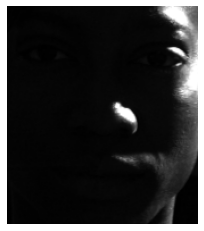

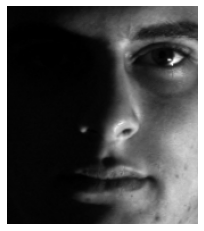

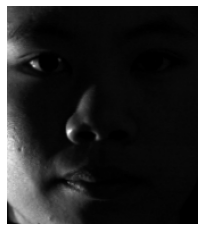

In [25]:
image(X.T[60], 192, 168)
image(X.T[104], 192, 168)
image(X.T[610], 192, 168)

This database was a bit challenging for eigenfaces. Hopefully fisher faces will be able to deal with lighting variation better...

### Fisher Faces

#### LDA vs PCA

The PCA attempts to capture the axes with the most variation in the data. Fisher's Linear Discriminant Analysis (LDA), the basis for fisher faces, aims to do something similar but with a twist: it attempts to find a basis that also effectively separates different classes.

I find this diagram the most useful in understanding the PCA vs the LDA:

<!-- ![Alt Text](image path "title") -->
<p><img src="https://www.researchgate.net/profile/Juwei-Lu/publication/267196113/figure/fig4/AS:655103732244483@1533200309806/PCA-feature-basis-vs-LDA-feature-basis-obtained-from-a-set-of-2D-training-samples.png" alt="Alt Text" title="Optional Title"></p>

The PCA would find the axis that creates the most variability in the data. The LDA, on the other hand, finds the axis that maximizes both the within class and between class scatter: in other words, it takes class difference into account. 

For this project, each subject will be categorized as a separate class. 

#### Finding a Basis Using the LDA

The LDA starts computes two matrices, a between scatter matrix, $ S_b $, and a within scatter matrix, $ S_w $, defined by:

$$ S_b = \sum_{i = 1}^{c}N_i(\mu_i - \mu)(\mu_i - \mu)^{T} $$
$$ S_w = \sum_{i = 1}^{c}\sum_{x_k \in X_i}(x_k - \mu_i)(x_k - \mu_i)^{T} $$

where $ c $ is the number of classes, $ N_i $ is the number of elements within a class, $ \mu_i $ is the mean element of that class, $ \mu $ is the mean of all elements, and $ x_k $ is the an element in a class.

The ideal LDA basis is formed from the eigenvectors, $ w $, derived from this equation:

$$ S_w^{-1}S_bw = \lambda w $$

I have only a vague understanding of where these scatter matrices come from and not enough to explain here. For the sake of coherence, I will say that you can also compute eigenfaces using the scatter matrix $ AA^{T} $. Finding the eigenvectors of this matrix is the same as finding the columns of $ U $ in the SVD of $ A $. Pretty neat connection!

#### A Singular $ S_w $

Unfortunately, $ S_w $ will almost always be a singular matrix when doing facial recognition. This makes it impossile to solve the above eigenvector equation. 

Why is $ S_w $ almost always singular? The rank of $ S_w $ is at most (the number of images) - (the number of classes). The dimensions of $ S_w $, however, are 32256 by 32256: much, much greater.

In order to overcome this, the fisher face algorithm performs the PCA on the image database to reduce the dimension of each image from 32256 to (the number of images) - (the number of classes).

The following accomplishes all this math through code. The one place it deviates is at the end, where I have to eliminate some very small imaginary numbers caused by calculator error.

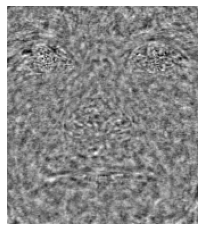

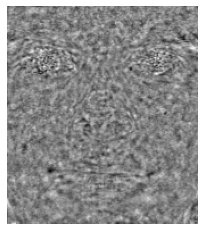

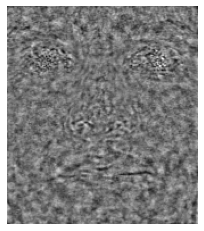

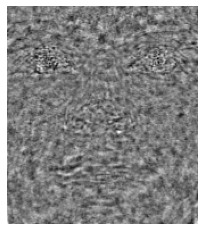

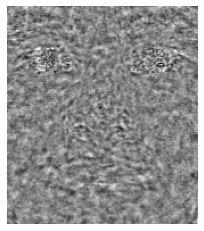

In [41]:
def fisherfaces(A, phi, classes):
    Phi = np.dot(phi.T, np.array([np.ones(A.shape[1])]))
    A = A - Phi 
    U, S, VT = randomized_svd(A, n_components = A.shape[1] - len(classes))
    phi = np.dot(U.T, phi.T)
    class_matrices = []
    for n in range(len(classes)):
        class_matrices.append(np.dot(U.T, compile_images(classes[n])))
        if n == 0:
            C = (np.array([np.average(class_matrices[n], axis = 1)]).T - phi)
            N = [class_matrices[n].shape[1]]
            X = class_matrices[n] - np.dot(phi, np.array([np.ones(class_matrices[n].shape[1])]))
            Sw = np.dot(X, X.T)
        else: 
            C = np.c_[C, (np.array([np.average(class_matrices[n], axis = 1)]).T - phi)]
            N.append(class_matrices[n].shape[1])
            X = class_matrices[n] - np.dot(phi, np.array([np.ones(class_matrices[n].shape[1])]))
            Sw += np.dot(X, X.T)
    N = np.diag(N) 
    Sb = np.linalg.multi_dot([C, N, C.T])
    S = np.dot(np.linalg.inv(Sw), Sb)
    l, W = np.linalg.eig(S)
    l = np.real(l)
    rank = np.linalg.matrix_rank(Sb)
    l = l[0:rank]
    W = np.real(W.T[0:rank].T)
    return W, U

W = np.load('Desktop/6.0001/W.npy') # Loading because fisher faces takes too long

for n in range(5):
    image(np.dot(U, W.T[n]), 192, 168)

Eigenfaces were terrifying, but fisher faces might be even worse...

### Classifying Fisher Faces

The classification process is almost exactly as the eigenface classification process. 

I will just let the fisher face results speak for themselves.

In [42]:
def classify_fisherfaces(W, U, phi, testfaces, classifiers):

    Phi = np.dot(phi.T, np.array([np.ones(classifiers.shape[1])]))
    classifiers_fp = np.linalg.multi_dot([W.T, U.T, (classifiers - Phi)])
    Phi = np.dot(phi.T, np.array([np.ones(testfaces.shape[1])]))
    testfaces_fp = np.linalg.multi_dot([W.T, U.T, (testfaces - Phi)])

    D = np.zeros((testfaces_fp.shape[1], classifiers_fp.shape[1]))
    
    for i in range(classifiers_fp.shape[1]): # ranging over 10 faces
        for j in range(testfaces_fp.shape[1]): # ranging over 620 faces
            difference = classifiers_fp.T[i] - testfaces_fp.T[j]
            d = (np.dot(difference, difference))**.5
            D[j, i] = d # columns of D correspond to classifiers; rows correspond to testfaces
    match = []
    for n in range(testfaces_fp.shape[1]):
        if min(D[n, :]) == D[n, int(n/int(testfaces_fp.shape[1]/classifiers_fp.shape[1]))]:
            match.append(1)
        else:
            match.append(0)
    for p in range(classifiers_fp.shape[1]):
        p_match = match[int(testfaces_fp.shape[1]/classifiers_fp.shape[1]) *p : int(testfaces_fp.shape[1]/classifiers_fp.shape[1])*(p+1)]
        print('Subject =', p)
        print(p_match)
        print('Accuracy:', sum(p_match)/len(p_match))
        print()
    print('Total accuracy:', sum(match)/len(match))
    print()
    
classify_fisherfaces(W, U, phi, X, P)

Subject = 0
[1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
Accuracy: 0.46774193548387094

Subject = 1
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1]
Accuracy: 0.8870967741935484

Subject = 2
[1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Accuracy: 0.6451612903225806

Subject = 3
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0]
Accuracy: 0.7580645161290323

Subject = 4
[1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

The results might not be perfect, but they are much, much better than eigenfaces. In particular, fisher faces does a better job with the various lighting conditions. 

### Bonus: Reconstructing Faces!

I'll leave this function in just for fun. This function projects a real person's face onto the space of $ r $ eigenfaces, where $ r $ ranges from $ 1 $ to $ 1000 $.

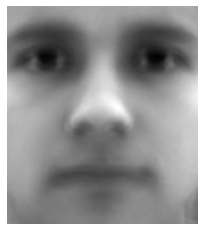

r = 1


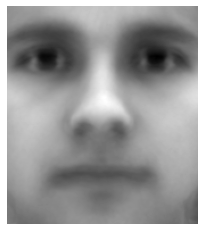

r = 5


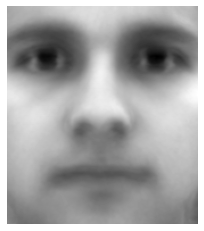

r = 10


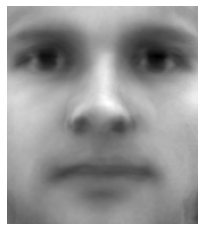

r = 25


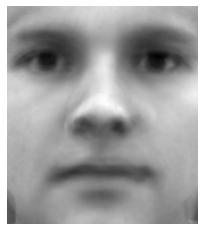

r = 50


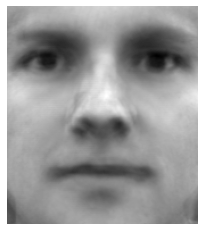

r = 100


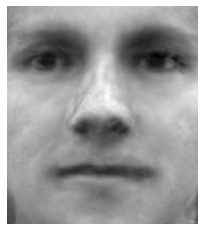

r = 200


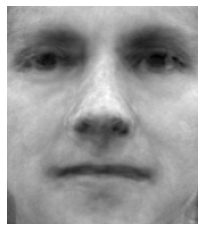

r = 400


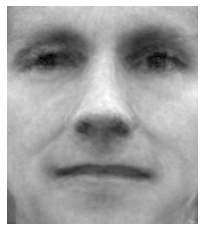

r = 1000


In [45]:
def reconstruct_face(A, phi, file):
    for r in [1, 5, 10, 25, 50, 100, 200, 400, 1000]:
        U = eigenfaces(A, phi, r)
        img = (np.array([vector(file)])).T
        img2 = np.linalg.multi_dot([U, U.T, img]) + phi.T  
        image(img2, 192, 168)
        print('r =', r)
        
reconstruct_face(A, phi, 'Desktop/6.0001/Faces/Matt_Pigg.JPG')